In [1]:
import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)


# Analyse comparative des quantités de points d'arrêts

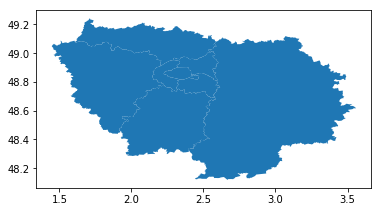

In [2]:
#contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
zones.plot()

In [3]:
#on charge les données
osm_stoppoints = pd.read_csv("../data/osm-transit-extractor_stop_points.csv", dtype=str)
gtfs_stoppoints = pd.read_csv("../data/gtfs_stops.txt", dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]
zones_with_stoppoints_count = zones_with_stoppoints_count.sort_values("name").reset_index().drop("index", axis=1)
zones_with_stoppoints_count


,name,geometry,nb_stoppoints_officiel,nb_stoppoints_osm,couverture_stoppoints_osm
0,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",5934,3685,62.099764
1,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3751,2781,74.140229
2,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",3056,2413,78.959424
3,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",4028,2601,64.572989
4,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",8262,4609,55.785524
5,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",4769,2981,62.507863
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3161,2716,85.922177
7,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",8385,3976,47.418008


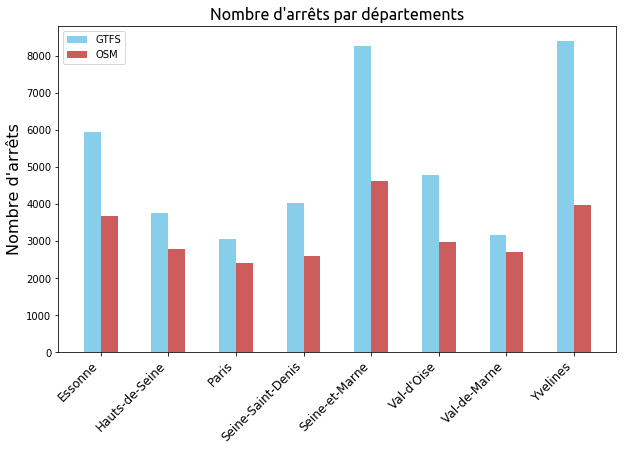

In [4]:
#histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind - width/2, zones_with_stoppoints_count["nb_stoppoints_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_stoppoints_count["nb_stoppoints_osm"], 
                width, color='IndianRed', label='OSM')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Nombre d\'arrêts par départements', 
             fontname='Ubuntu', fontsize=16,
             fontstyle='normal', fontweight='normal')
ax.set_ylabel('Nombre d\'arrêts', fontsize=16)

ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()


In [5]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_stoppoints_count, data=zones_with_stoppoints_count, columns=['name', 'couverture_stoppoints_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [6]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

61.82947893676231

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

# Analyse comparative en utilisant les lignes desservies

In [7]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv("../data/gtfs_routes.txt", dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv("../data/osm-transit-extractor_lines.csv", dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [8]:
len(osm_lines) * 100.0 / len(gtfs_lines)

49.667774086378735

In [9]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv("../data/opendata_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
#gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [10]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

zones_with_routepoints_count.sort_values("name", inplace=True)
zones_with_routepoints_count

,name,geometry,nb_stops_officiel,nb_stops_osm,couverture_osm
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14214,3677,25.868862
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7557,3740,49.490539
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",6671,4457,66.811572
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8421,2303,27.348296
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26317,3658,13.899761
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10153,3267,32.177681
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7540,3411,45.238727
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22149,1780,8.036480


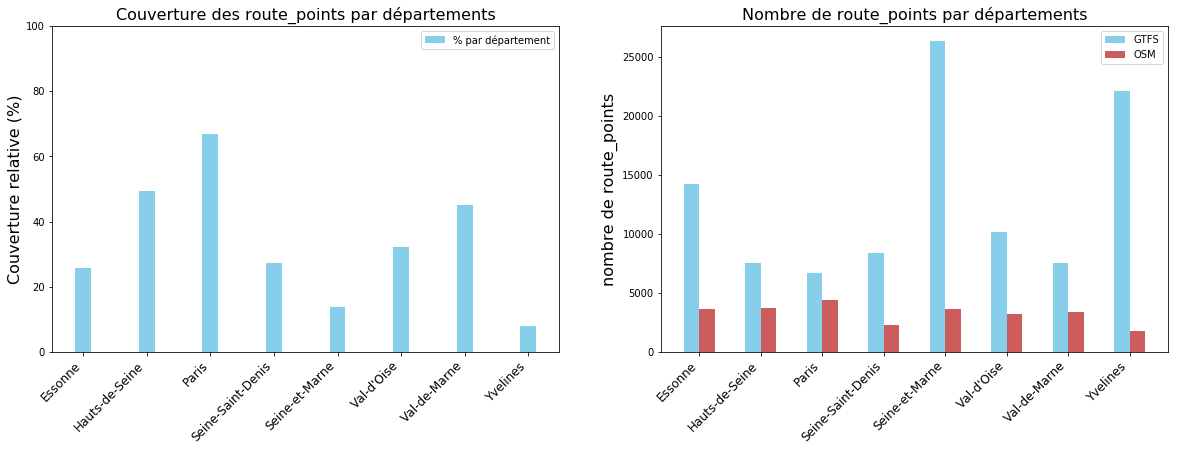

In [34]:
# histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig = plt.figure(figsize=(20, 6))
# 1er graph
ax = fig.add_subplot(121)
rects = ax.bar(ind, zones_with_routepoints_count["couverture_osm"], 
                width, color='SkyBlue', label='% par département')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 100)
ax.set_ylabel('Couverture relative (%)', fontsize=16)
ax.set_title('Couverture des route_points par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()

# 2eme graph
ax = fig.add_subplot(122)
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
rects1 = ax.bar(ind - width/2, zones_with_routepoints_count["nb_stops_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_routepoints_count["nb_stops_osm"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('nombre de route_points', fontsize=16)
ax.set_title('Nombre de route_points par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()




In [12]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_routepoints_count, data=zones_with_routepoints_count, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlGn', highlight=True)


m

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [13]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

25.394189268782526

In [14]:
#TODO : nombre moyen de terminus par ligne, pour OSM

#TODO : nombre moyen de terminus par ligne, pour le GTFS

# Analyse quantitative par réseau

TODO : faire une table de correspondance entre les réseaux des deux sources car on en écarte plus de la moitié parce que ça ne matche pas exactement

Et trouver un moyen sympa de le visualiser

#### osm_routepoints

In [15]:
osm_routepoints_cleaned = osm_routepoints.copy()

osm_routepoints_cleaned.replace(to_replace="Navettes Aéroports De Paris", value="ADP", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Les Courriers de l'Île-de-France", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Keolis CIF", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Bus Val d'Oise", value="Busval d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Transdev CEAT", value="CEAT", inplace=True)
osm_routepoints_cleaned.replace(to_replace="La Navette Paris-Saclay", value="Paris-Saclay", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Réseau interurbain de Rambouillet", value="Rambouillet Interurbain", inplace=True)
osm_routepoints_cleaned.replace(to_replace="R'bus", value="rbus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Canton de Perthes en Gâtinais", value="Réseau du Canton de Perthes", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Seine-et-Marne Express", value="Seine et Marne Express", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Sénart Bus", value="Sénart-Bus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Tice", value="TICE", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYbus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYBUS", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SqyBus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="TransVO", value="Trans Val d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Still", value="STILL", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Î", value="I", inplace=True)



osm_networks = pd.DataFrame(osm_routepoints_cleaned.groupby('osm_network').size()).reset_index()
osm_networks.rename(columns={0: 'osm_routepoints_count'}, inplace=True)
osm_networks["osm_network_lower"] = osm_networks["osm_network"].str.lower()

gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
gtfs_agency_line_count = gtfs_routepoints.groupby('gtfs_agency_name').gtfs_route_short_name.nunique().reset_index()
gtfs_networks = gtfs_networks.merge(gtfs_agency_line_count, how='left', on='gtfs_agency_name')
gtfs_networks.rename(columns={0: 'gtfs_routepoints_count', "gtfs_route_short_name":"gtfs_lines_count"}, inplace=True)
gtfs_networks['gtfs_agency_name_lower'] = gtfs_networks['gtfs_agency_name'].str.lower()
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network_lower'], left_on=['gtfs_agency_name_lower'])
networks.drop('osm_network', axis=1, inplace=True)
networks.drop('osm_network_lower', axis=1, inplace=True)
networks.drop('gtfs_agency_name_lower', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_routepoints_count'] * 100.0 / networks['gtfs_routepoints_count']
#osm_routepoints_cleaned[osm_routepoints_cleaned["osm_network"].str.contains("Paris")]
#osm_routepoints_cleaned[osm_routepoints_cleaned['osm_network'].str.contains("ADP")]
networks

,gtfs_agency_name,gtfs_routepoints_count,gtfs_lines_count,osm_routepoints_count,osm_couverture
0,ADP,15,2,4,26.666667
1,AUTOCARS DOMINIQUE,32,1,28,87.500000
2,Apolo 7,946,7,192,20.295983
3,Arlequin,1086,10,77,7.090239
4,Autobus du Fort,45,3,11,24.444444
5,Aérial,637,9,66,10.361068
6,Bus en Seine,995,13,33,3.316583
7,Busval d'Oise,2345,32,737,31.428571
8,CARS PERRON,97,1,30,30.927835
9,CEAT,1253,32,176,14.046289


### Top 10 des réseaux (les plus mappés et les moins mappés)

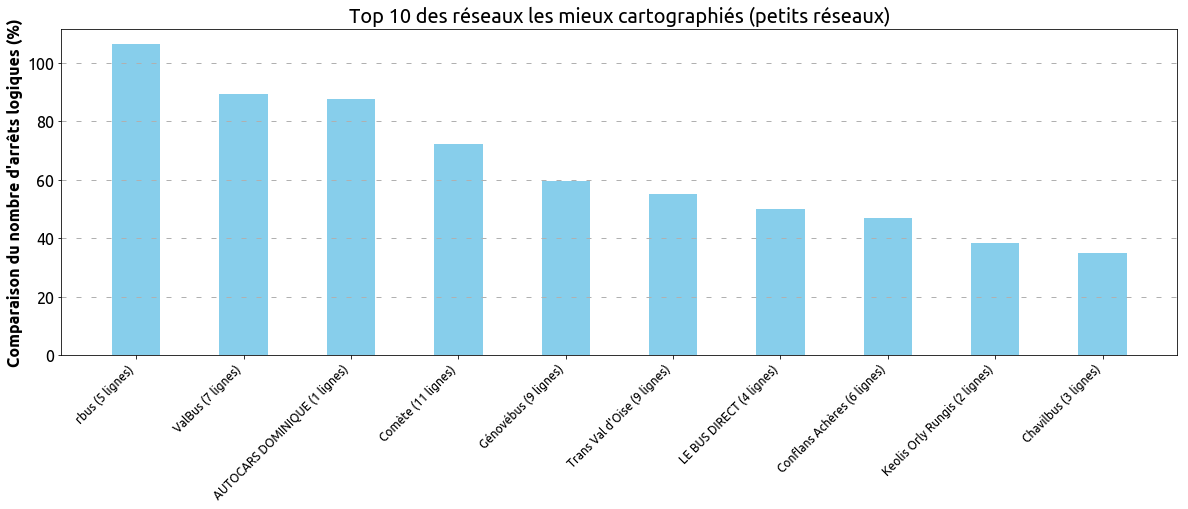

In [16]:
#networks_top_10 = networks.sort_values("osm_couverture", ascending=False).head(10)
networks_top_10 = networks[networks["gtfs_lines_count"] < 20].sort_values("osm_couverture", ascending=False).head(10)
networks_top_10["label"] = networks_top_10["gtfs_lines_count"].apply(str)
networks_top_10["label"] = networks_top_10["gtfs_agency_name"] + ' (' + \
    networks_top_10["label"].astype(str) + ' lignes)'

#networks_top_10

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks_top_10.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_top_10["osm_couverture"], 
                width, color='SkyBlue')
ax.set_ylabel('Comparaison du nombre d\'arrêts logiques (%)')
ax.set_title('Top 10 des réseaux les mieux cartographiés (petits réseaux)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_top_10["label"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)


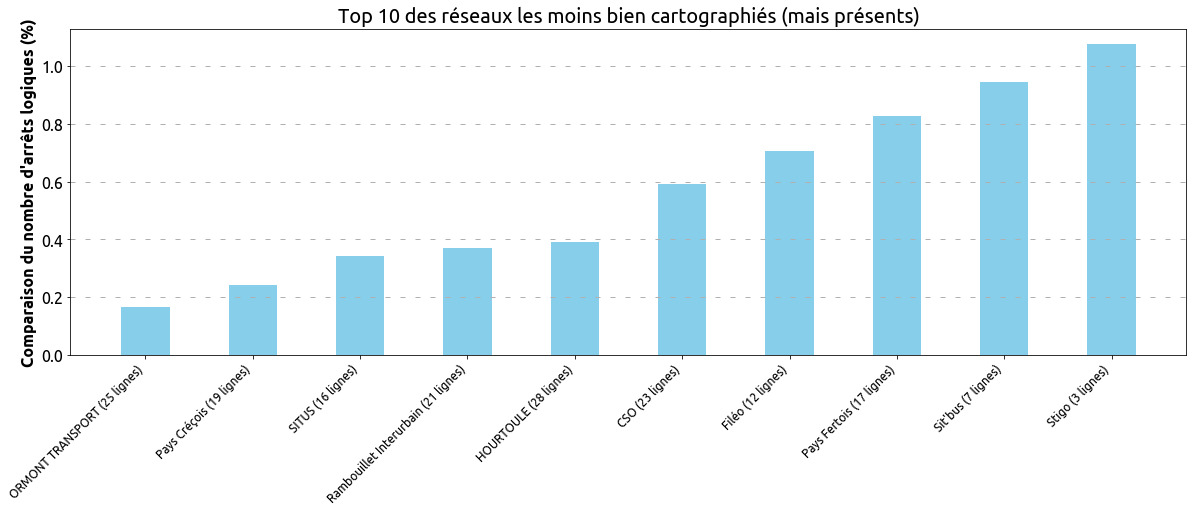

In [17]:
networks_flop_10 = networks.sort_values("osm_couverture", ascending=True).head(10)
networks_flop_10["label"] = networks_flop_10["gtfs_lines_count"].apply(str)
networks_flop_10["label"] = networks_flop_10["gtfs_agency_name"] + ' (' + \
    networks_flop_10["label"].astype(str) + ' lignes)'

#Le style du graphique est le même que le précédent :)
ind = np.arange(networks_top_10.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_flop_10["osm_couverture"], width, color='SkyBlue')
ax.set_ylabel('Comparaison du nombre d\'arrêts logiques (%)')
ax.set_title('Top 10 des réseaux les moins bien cartographiés (mais présents)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_flop_10["label"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)



### comparaisons par réseaux (à supprimer ?)

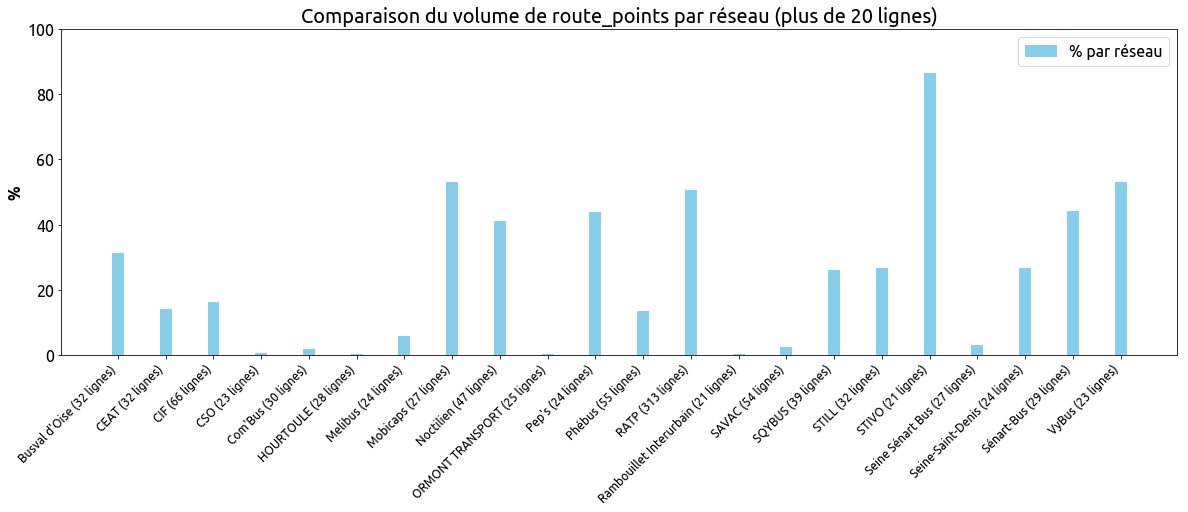

In [18]:
# Réseaux de plus de 20 lignes
networks_20lines_and_more = networks[networks["gtfs_lines_count"] >= 20].copy()
networks_20lines_and_more["label"] = networks_20lines_and_more["gtfs_lines_count"].apply(str)
networks_20lines_and_more["label"] = networks_20lines_and_more["gtfs_agency_name"] + ' (' + \
    networks_20lines_and_more["label"].astype(str) + ' lignes)'
width = 0.25  # the width of the bars
ind = np.arange(networks_20lines_and_more.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_20lines_and_more['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau (plus de 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_20lines_and_more["label"], rotation=45, ha='right')
ax.legend()


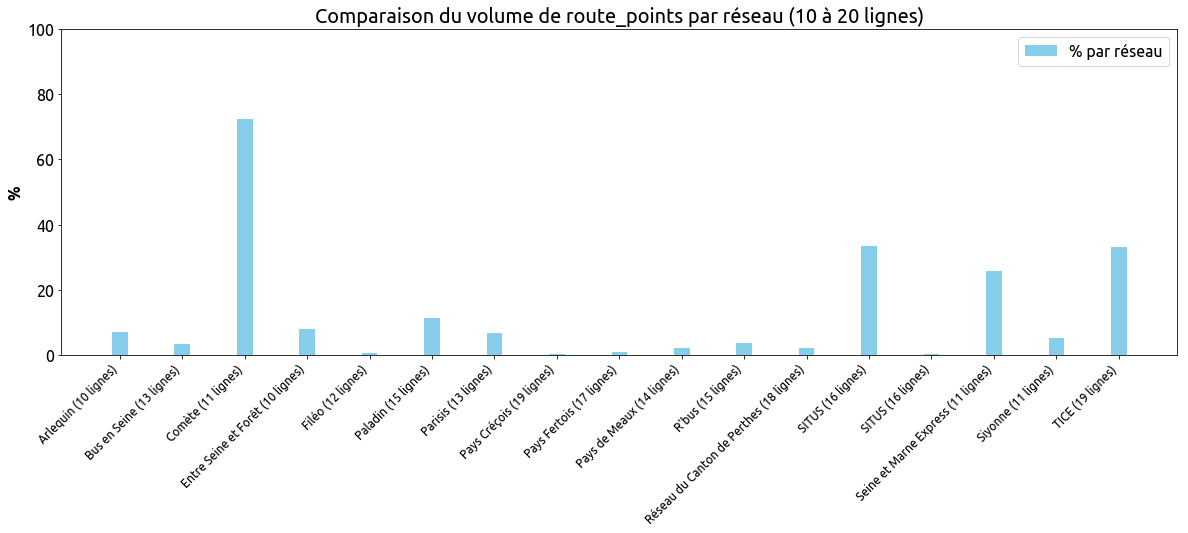

In [19]:
# Réseaux de moins de 20 lignes
networks_less_than_20lines = networks[(networks["gtfs_lines_count"] < 20) & (networks["gtfs_lines_count"] >= 10)].copy()
networks_less_than_20lines["label"] = networks_less_than_20lines["gtfs_lines_count"].apply(str)
networks_less_than_20lines["label"] = networks_less_than_20lines["gtfs_agency_name"] + ' (' + \
    networks_less_than_20lines["label"].astype(str) + ' lignes)'
width = 0.25  # the width of the bars
ind = np.arange(networks_less_than_20lines.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_less_than_20lines['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau (10 à 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_less_than_20lines["label"], rotation=45, ha='right')
ax.legend()

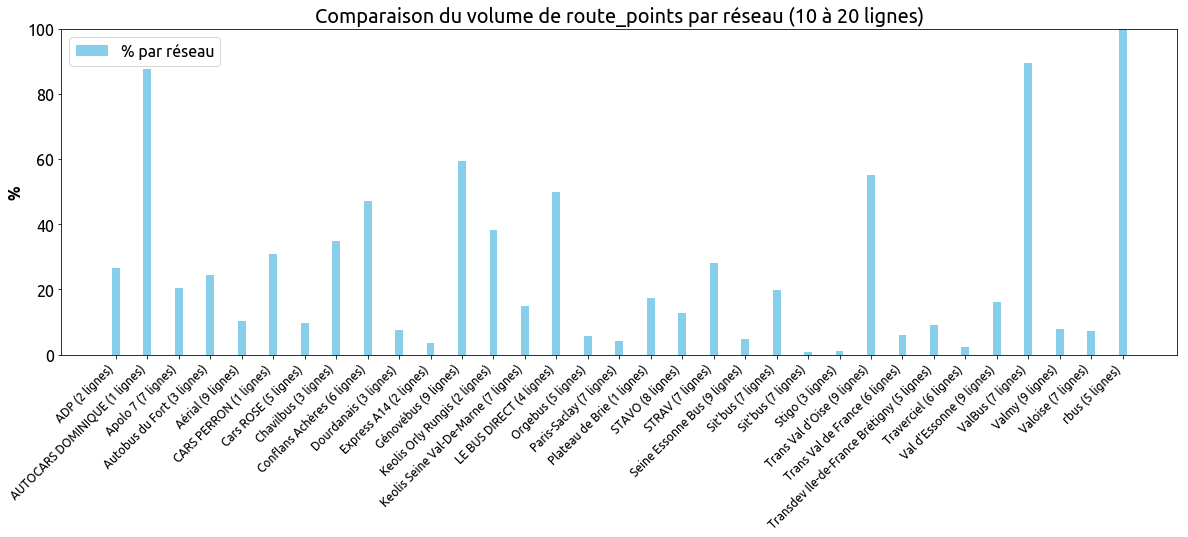

In [20]:
# Réseaux de moins de 10 lignes
networks_less_than_10lines = networks[networks["gtfs_lines_count"] < 10].copy()
networks_less_than_10lines["label"] = networks_less_than_10lines["gtfs_lines_count"].apply(str)
networks_less_than_10lines["label"] = networks_less_than_10lines["gtfs_agency_name"] + ' (' + \
    networks_less_than_10lines["label"].astype(str) + ' lignes)'
width = 0.25  # the width of the bars
ind = np.arange(networks_less_than_10lines.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind, networks_less_than_10lines['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau (10 à 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_less_than_10lines["label"], rotation=45, ha='right')
ax.legend()

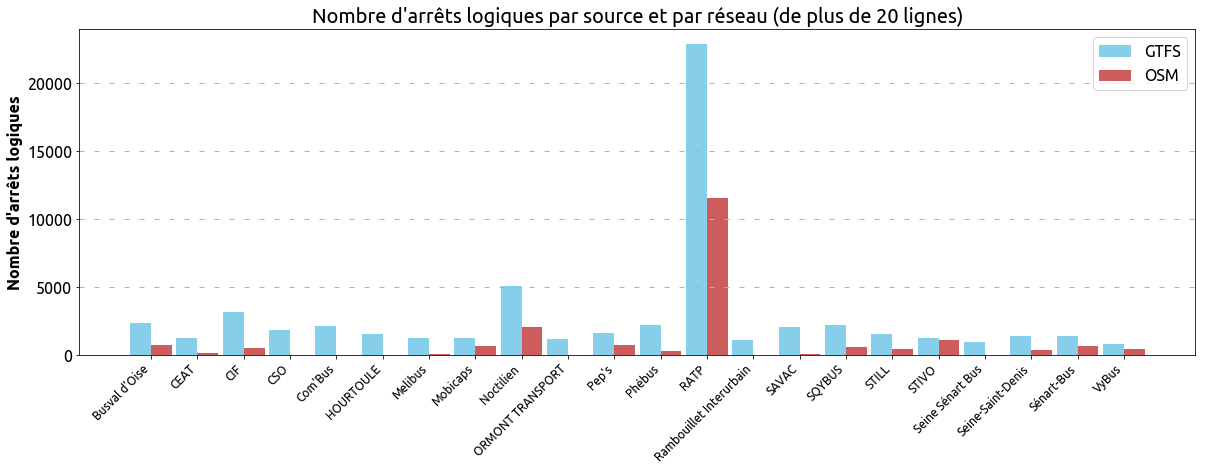

In [21]:
# la première ligne fait un reset du style 
mpl.rcParams.update(inline_rc)
# plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks_20lines_and_more.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects1 = ax.bar(ind - width/2, networks_20lines_and_more["gtfs_routepoints_count"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, networks_20lines_and_more["osm_routepoints_count"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('Nombre d\'arrêts logiques')
ax.set_title('Nombre d\'arrêts logiques par source et par réseau (de plus de 20 lignes)')
ax.set_xticks(ind)
ax.set_xticklabels(networks_20lines_and_more["gtfs_agency_name"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)

ax.legend()

# Analyse qualitative

uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

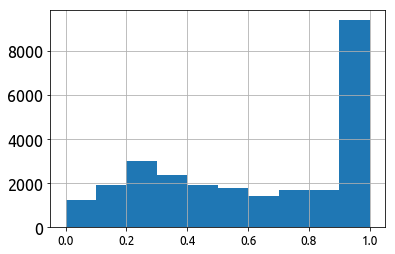

In [22]:
osm_routepoints = pd.read_csv("../data/osm_routepoints_for_matching.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints.fillna("", inplace=True)
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
routepoints.fillna("", inplace=True)

def compute_similarity_for_terminus(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_for_terminus(*x), axis=1)
routepoints['destination_confidence'].hist()

In [23]:
routepoints = routepoints[routepoints['destination_confidence'] >= 0.6]

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [24]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

## Mesures qualitatives

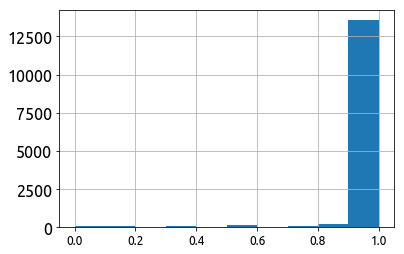

In [25]:
# différences sur les codes de ligne
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()

In [26]:
routepoints_ = routepoints[routepoints['line_code_confidence'] < 0.8]
routepoints_ = routepoints_[['gtfs_route_short_name', 'osm_code']]
grouped = routepoints_.groupby(['gtfs_route_short_name', 'osm_code'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df

,gtfs_route_short_name,osm_code
21422,CHOISYB,582
21340,NAVETTE,524
21330,BIEVRES,513
21336,NEY-FLA,519
26171,TRAVERSE,Traverse
10216,CITA,Citalien
2022,7,FA
9548,Tzen1,TZen 1
10326,DIRECT 4,Direct 4
10328,MONTMAR,Montmartrobus


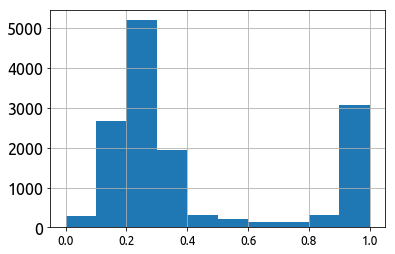

In [27]:
# différences sur les noms des arrêts
routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()

In [28]:
routepoints_ = routepoints[routepoints['name_confidence'] < 0.5]
routepoints_ = routepoints_[['gtfs_stop_name', 'osm_name']]
grouped = routepoints_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df.head()

,gtfs_stop_name,osm_name
18364,RUE DES OLIVETTES,Rue des Olivettes
1314,ALBERT 1ER,Albert 1er
13309,RUE VIEILLE DU TEMPLE - MAIRIE DU 4E,Rue Vieille du Temple - Mairie du 4e
8951,ST EXUPERY,Saint-Exupéry
17800,MOZART - MALESHERBES,Mozart - Malesherbes


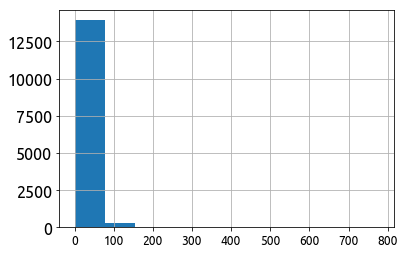

In [29]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()
#TODO : trouver une meilleure représentation graphique qui montre que 
#l'essentiel est en dessous de 50 m, mais qu'il y a des points bien bien loin
# ptet une boite à moustache ?

In [30]:
routepoints['distance'].mean()

18.170543578063477

In [31]:
routepoints_ = routepoints[routepoints['distance'] > 80]
len(routepoints_)

358

In [32]:
routepoints_ = routepoints_.sort_values(by='distance') 
#TODO : trouver un moyen sympa de visualiser ces écarts de distance
routepoints_

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_lon,osm_network,osm_code,osm_osm:ref:FR:STIF,osm_lat,osm_line_id,destination_confidence,line_code_confidence,name_confidence,distance
18883,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,2.3332596,RATP,184,28582,48.797711799999995,Line:Relation:1259529,0.636364,1.000000,0.210526,80.228791
18465,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,2.3332596,RATP,162,28582,48.797711799999995,Line:Relation:1991746,0.800000,1.000000,0.210526,80.228791
18882,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,2.3332596,RATP,184,28582,48.797711799999995,Line:Relation:1259529,0.636364,1.000000,0.210526,80.228791
18464,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,2.3332596,RATP,162,28582,48.797711799999995,Line:Relation:1991746,0.800000,1.000000,0.210526,80.228791
23281,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,2.3179000999999997,Noctilien,N15,24603,48.891836,Line:Relation:1537048,0.851852,1.000000,0.263158,80.289990
21641,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,2.3179000999999997,Noctilien,N51,24603,48.891836,Line:Relation:1553501,0.971429,1.000000,0.263158,80.289990
21642,StopPoint:59:4016293,100987753:N51,24603,BROCHANT - CARDINET,48.891322,2.318669,1,GARE SAINT-LAZARE.,N51,Noctilien,...,2.3179000999999997,Noctilien,N51,24603,48.891836,Line:Relation:1553501,0.971429,1.000000,0.263158,80.289990
12163,StopPoint:59:4016293,100100054:54,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PORTE D'AUBERVILLIERS,54,RATP,...,2.3179000999999997,RATP,54,24603,48.891836,Line:Relation:1257186,1.000000,1.000000,0.263158,80.289990
23280,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,2.3179000999999997,Noctilien,N15,24603,48.891836,Line:Relation:1537048,0.851852,1.000000,0.263158,80.289990
14398,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PLACE DE CLICHY,74,RATP,...,2.3179000999999997,RATP,74,24603,48.891836,Line:Relation:937390,1.000000,1.000000,0.263158,80.289990
